# firing rates vs contextual modulation
how is the fring rate of the contexts, and or the probe related to the value of the contextual modulation metrics


In [1]:
from src.root_path import  config_path
from src.visualization.fancy_plots import savefig


import itertools as itt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from configparser import ConfigParser
import pathlib as pl
import joblib as jl
import statsmodels.api as sm
from IPython.display import display

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-09-23 184528.log
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


In [2]:
#general plottin formating
plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])

loads dataframes with fire rates for different contexts*probes*neurons
loads dataframes with the contextual modulation metrics

In [3]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

# firing rate dataframe
# so far this datadrame only contains firing rates for the 10 sound experiemtns
ctx_fr_DF_file = pl.Path(config['paths']['analysis_cache']) / '210917_context_firing_rate_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_stim_type-permutations_zscore-True'
ctx_fr_DF = jl.load(ctx_fr_DF_file)

# # 4 sound file
# DF4_file = pl.Path(config['paths']['analysis_cache']) /'210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'
# DF4 = jl.load(DF4_file)

# 10 soundfile
DF10_file = pl.Path(config['paths']['analysis_cache']) /'210902_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_stim_type-permutations_zscore-True'
DF10 = jl.load(DF10_file)

dataframe preprocecing. selects only relevant jsubsets and columns

In [4]:
mult_comp_cont = 4
# pulls DF, removes unused columns and data, refactor redundant id columns and create probe_id
def format_dataframe(DF):
    ff_probe = DF.probe != 'mean'
    ff_pairs = DF.context_pair != 'mean'
    try:
        ff_mean = DF.mean_signif_type == 'shuffles'
    except:
        print('no mean_signif_type, taking all values')
        ff_mean = pd.Series(np.full(DF.shape[0], True))


    try:
        ff_stim = DF.stim_type == 'permutations'
    except:
        print('no stim_type, taking all values')
        ff_stim = pd.Series(np.full(DF.shape[0], True))


    ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
    # ff_corr = DF.mult_comp_corr == 'consecutive_3'
    ff_corr = DF.mult_comp_corr == f'consecutive_{mult_comp_cont}'
    ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_sum'])

    good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
                'probe', 'metric', 'value']
    filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

    filtered['probe'] = [int(p) for p in filtered['probe']]
    filtered['context_pair'] = [f"{int(cp.split('_')[0]):02d}_{int(cp.split('_')[1]):02d}"
                                for cp in filtered['context_pair']]

    # rename metrics and analysis for ease of ploting
    filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                     'significant_abs_mean': "mean d'",
                                                     'significant_abs_sum': "integral (d'*ms)"})
    filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                         'fdPCA': 'population',
                                                         'pdPCA': 'probewise pop',
                                                         'LDA': 'pop ceiling'})

    filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
    filtered = filtered.drop(columns=['cellid', 'siteid'])

    filtered['value'] = filtered['value'].fillna(value=0)

    # permutation related preprocesing.
    # creates a new column relating probe with  context pairs
    ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
    prb = np.asarray(filtered.probe, dtype=int)

    silence = ctx == 0
    same = ctx == prb[:,None]
    different = np.logical_and(~silence, ~same)

    name_arr = np.full_like(ctx, np.nan, dtype=object)
    name_arr[silence] = 'silence'
    name_arr[same] = 'same'
    name_arr[different] = 'diff'
    comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

    # swaps clasification names to not have repetitions i.e. diff_same == same_diff
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
    comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
    comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

    filtered['trans_pair'] = comp_name_arr

    ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
    pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
    pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

    full_long = filtered # saves long format for subsamplig analysis

    return pivoted, full_long
pivoted, full_long = format_dataframe(DF10)


ff_amplitude = pivoted["integral (d'*ms)"] > 0
ff_analysis = pivoted.analysis == 'single cell'
ctx_pair_filtered = pivoted.loc[ff_amplitude & ff_analysis, :]
ctx_pair_filtered['ctx_0'] = ctx_pair_filtered['context_pair'].apply(lambda x: int(x.split('_')[0]))
ctx_pair_filtered['ctx_1'] = ctx_pair_filtered['context_pair'].apply(lambda x: int(x.split('_')[1]))

ctx_pair_filtered = ctx_pair_filtered.loc[:, ['analysis', 'id', 'probe',
                            'center of mass (ms)',
                            "integral (d'*ms)",
                            'ctx_0', 'ctx_1']].set_index(['analysis',  'id', 'probe', 'ctx_0', 'ctx_1'])

no mean_signif_type, taking all values
no stim_type, taking all values


<ipython-input-4-7e20789b885c>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctx_pair_filtered['ctx_0'] = ctx_pair_filtered['context_pair'].apply(lambda x: int(x.split('_')[0]))
<ipython-input-4-7e20789b885c>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctx_pair_filtered['ctx_1'] = ctx_pair_filtered['context_pair'].apply(lambda x: int(x.split('_')[1]))


Merges the modulation metric DF with the context firing rate DF
this still keeps track of all

In [5]:
# merges the first context
fr_filtered = ctx_fr_DF.rename(columns={'context':'ctx_0'}).set_index(['analysis', 'id', 'probe', 'ctx_0'])
merge = pd.merge(left=ctx_pair_filtered, right=fr_filtered,
                 left_index=True, right_index=True)

# to keep track of specific context firing rates, rename columns. To ensure propper alignment of time values, set time  as index
merge = merge.rename(columns={'firing rate':'ctx_0_fr'}).set_index(['time (ms)'], append=True)

# merges the second context into the first merge.
fr_filtered = ctx_fr_DF.rename(columns={'context':'ctx_1'}).set_index(['analysis', 'id', 'probe', 'ctx_1', 'time (ms)'])


merge = pd.merge(left=merge, right=fr_filtered,
                  left_index=True, right_index=True
                  ).rename(columns={'firing rate':'ctx_1_fr'}
                  ).reorder_levels(['analysis','id','probe', 'ctx_0', 'ctx_1', 'time (ms)'])

## time mean firing rate relations
simply collapses across the time dimension and compares the mean firing rate of each context, the mean between contexts
or their difference.

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/ctx_fr/summary_ctx_fr_influence.png


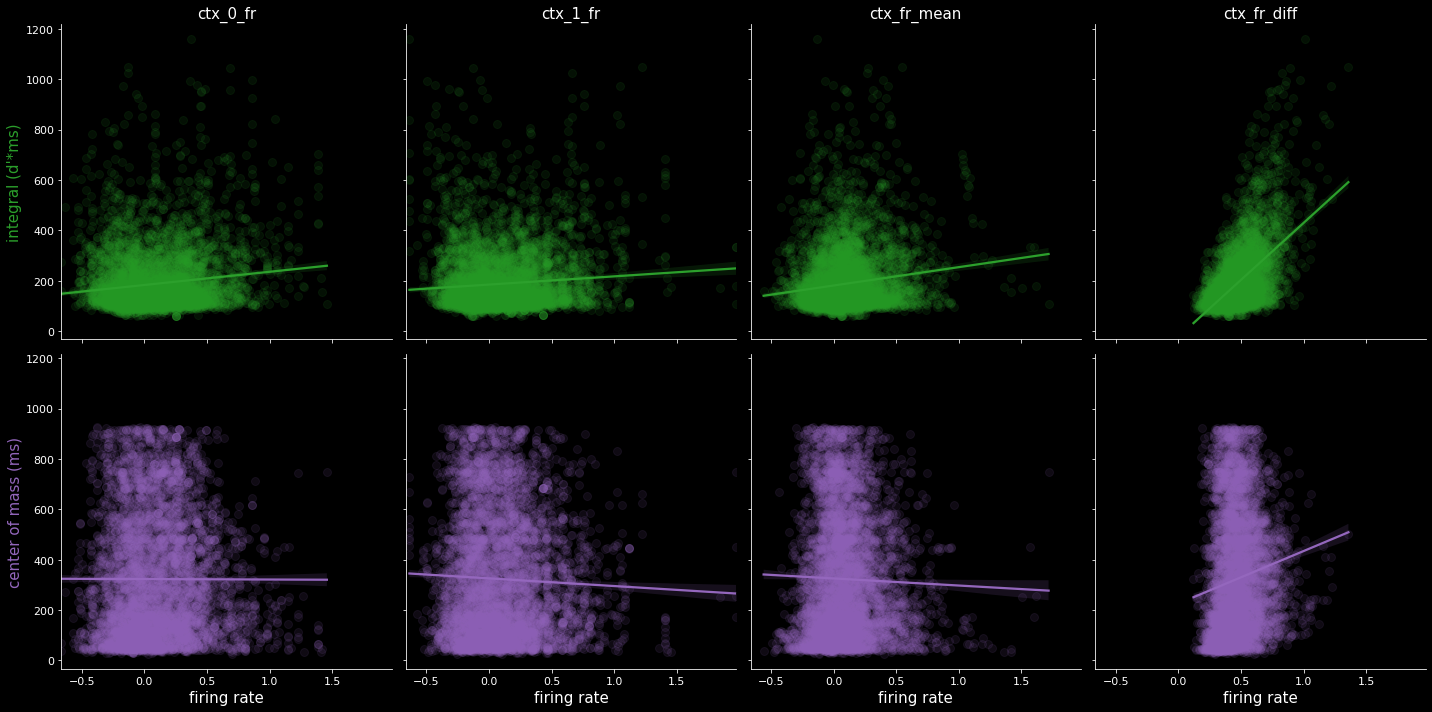

In [6]:
mean_fr_merge = merge.copy()
mean_fr_merge['ctx_fr_mean'] = mean_fr_merge.loc[:, ['ctx_0_fr','ctx_1_fr']].mean(axis=1)
mean_fr_merge['ctx_fr_diff'] = mean_fr_merge.loc[:, ['ctx_0_fr','ctx_1_fr']].agg(lambda x: np.abs(x[0]-x[1]), axis=1)

mean_fr_merge = mean_fr_merge.groupby(['analysis', 'id', 'probe', 'ctx_0', 'ctx_1']).agg('mean')

# model = sm.OLS(mean_fr_merge["center of mass (ms)"], mean_fr_merge.loc[:,['ctx_0_fr', 'ctx_1_fr']])
# res = model.fit()
# res.summary()

# melt for easy plot in seaborn

molten_fr = mean_fr_merge.reset_index(
                        ).melt(id_vars=['analysis', 'id', 'probe', 'center of mass (ms)',"integral (d'*ms)"],
                         value_vars=['ctx_0_fr', 'ctx_1_fr', 'ctx_fr_mean', 'ctx_fr_diff'], var_name='context', value_name='firing_rate')

molten = molten_fr.melt(id_vars=['analysis', 'id', 'probe', 'context', 'firing_rate'],
                         value_vars=['center of mass (ms)', "integral (d'*ms)"], var_name='metric', value_name='value')

met_ord =["integral (d'*ms)", 'center of mass (ms)']
met_color = ['C2', 'C4']
g = sns.lmplot(x='firing_rate', y='value', row='metric', col='context', row_order=met_ord,
               hue='metric', hue_order=met_ord, palette= met_color,
               data=molten, scatter_kws={'alpha':0.1})

g.set_titles(template="")
g.set_axis_labels("",
                  "")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
g.set_axis_labels("firing rate", "")
_ = g.axes_dict[("integral (d'*ms)", 'ctx_0_fr')].set_ylabel("integral (d'*ms)", color='C2')
_ = g.axes_dict[('center of mass (ms)', 'ctx_0_fr')].set_ylabel("center of mass (ms)", color='C4')
fig = g.fig
title = 'summary_ctx_fr_influence'
savefig(fig, 'ctx_fr', title)

# Time wise firing rate relations
same as before, but focusing only on the context firing rate difference at all time points prior the probe onset

In [7]:
diff_fr = merge.copy()
diff_fr['ctx_fr_diff'] =  diff_fr.loc[:, ['ctx_0_fr','ctx_1_fr']].agg(lambda x: np.abs(x[0]-x[1]), axis=1)
diff_fr['ctx_fr_mean'] =  diff_fr.loc[:, ['ctx_0_fr','ctx_1_fr']].agg('mean', axis=1)
diff_fr = diff_fr.drop(columns=['ctx_0_fr','ctx_1_fr']).reset_index()
diff_fr['ms_to_probe'] = diff_fr['time (ms)'].apply(lambda x: x -1000)

molten = diff_fr.melt(id_vars=['analysis', 'id', 'probe', 'ctx_0', 'ctx_1',
                               'time (ms)', 'ms_to_probe',
                               'ctx_fr_mean', 'ctx_fr_diff'],
                      value_vars=['center of mass (ms)', "integral (d'*ms)"], var_name='metric', value_name='value')

metric = "integral (d'*ms)"
metric = 'center of mass (ms)'
def plot_at_times(metric, fr, color):
    toplot = molten.loc[molten.metric == metric, : ]

    g = sns.lmplot(x=fr, y='value', col='ms_to_probe', col_wrap=6,
                   data=toplot,  scatter_kws={'alpha':0.1, 'color':color, 's':5}, line_kws={'color':color})

    g.set_titles(row_template="", col_template="{col_name:.2f} ms")
    g.set_axis_labels('firing rate', metric,)
    g.fig.set_size_inches(10, 10)

    return g

## context firing rate absolute difference
### amplitude

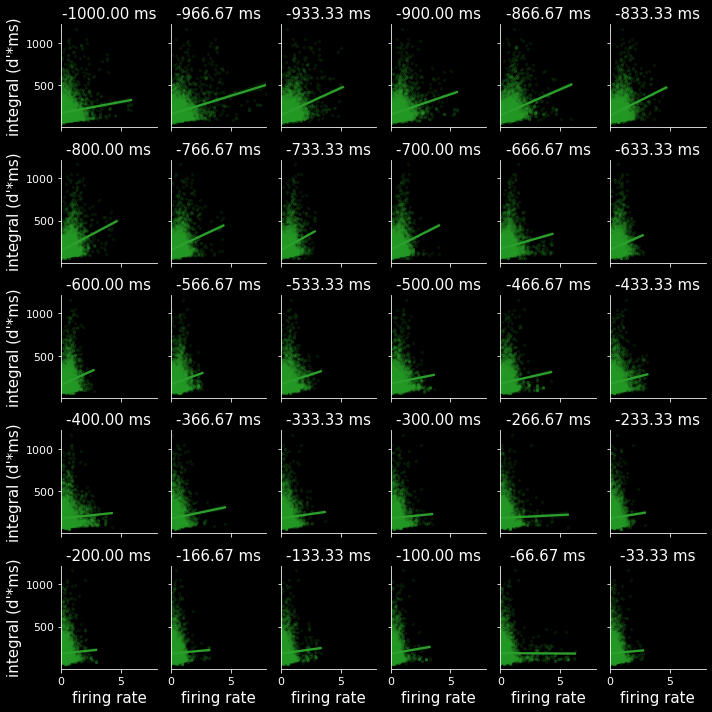

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/ctx_fr/timewise_ctx_fr_vs_amplitude.png


In [8]:
g = plot_at_times(metric="integral (d'*ms)", fr='ctx_fr_diff', color='C2')
plt.show()
title = 'timewise_ctx_fr_vs_amplitude'
savefig(g.fig, 'ctx_fr', title)

### duration

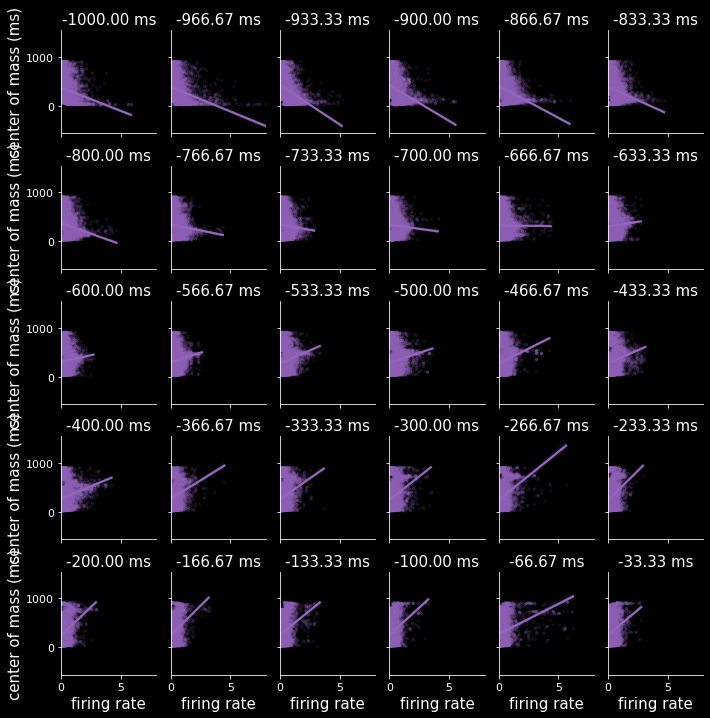

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/ctx_fr/timewise_ctx_fr_vs_duration.png


In [9]:
g = plot_at_times(metric='center of mass (ms)', fr='ctx_fr_diff', color='C4')
plt.show()
title = 'timewise_ctx_fr_vs_duration'
savefig(g.fig, 'ctx_fr', title)



## context firing rate mean
### amplitude

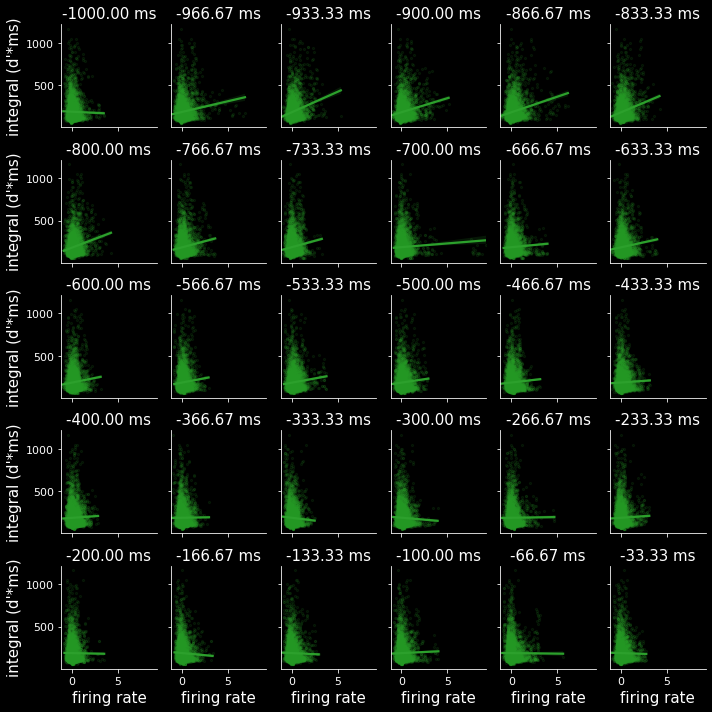

In [10]:
g = plot_at_times(metric="integral (d'*ms)", fr='ctx_fr_mean', color='C2')
plt.show()
title = 'timewise_ctx_fr_vs_amplitude'
# savefig(g.fig, 'ctx_fr', title)

### duration

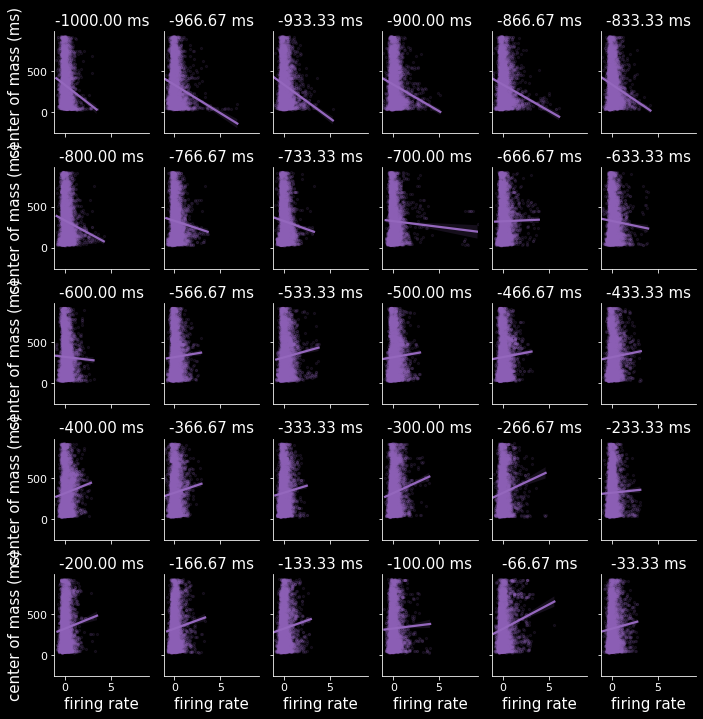

In [11]:
g = plot_at_times(metric='center of mass (ms)', fr='ctx_fr_mean', color='C4')
plt.show()
title = 'timewise_ctx_fr_vs_duration'
# savefig(g.fig, 'ctx_fr', title)

#### sanity check of mean acrross time points
these plots indeed coincide with the plots summarizing the time mean firing rate relatio with metrics

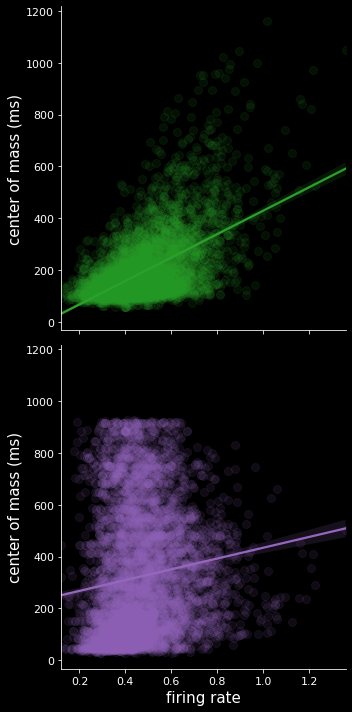

In [12]:
# sanity check, get the mean and plot by itself
toplot_mean = molten.drop(columns=['ms_to_probe', 'time (ms)', ]).groupby(['analysis', 'id', 'probe', 'ctx_0', 'ctx_1', 'metric', 'value'], axis=0).agg('mean').reset_index()


g = sns.lmplot(x='ctx_fr_diff', y='value', row='metric', row_order=met_ord,
               hue='metric', hue_order=met_ord, palette=met_color,
               data=toplot_mean, scatter_kws={'alpha':0.1})

g.set_titles(row_template="", col_template="{col_var} {col_name:.2f}")
g.set_axis_labels('firing rate', metric)


## multivariate regression
Given the clear effect of both mean firing rate and eabsolute firing rate difference in on the contextual modulation
metrics, defines the weight of these 20 variable (10 time points * (fr_mean or fr_diff))

In [13]:
# pivot data to wide format for regression
to_regress = diff_fr.pivot_table(index=['analysis', 'id', 'probe', 'ctx_0', 'ctx_1', 'center of mass (ms)', "integral (d'*ms)"],
                                 values=['ctx_fr_diff', 'ctx_fr_mean'],
                                 columns=['ms_to_probe'],
                                 aggfunc='first').reset_index(level=['center of mass (ms)', "integral (d'*ms)"])

display(to_regress)

center of mass (ms)  \
ms_to_probe                                                      
analysis    id           probe ctx_0 ctx_1                       
single cell TNC013a-03-1 3     0     4              632.055818   
                               3     4              485.676073   
                                     8              452.083436   
                               4     7              514.507737   
                                     9              628.442847   
...                                                        ...   
            TNC018a-48-1 10    7     9              213.394586   
            TNC018a-50-1 6     0     6               87.558538   
                               1     5              212.135369   
                                     6               98.472314   
                               6     9              112.066733   

                                           integral (d'*ms) ctx_fr_diff  \
ms_to_probe                                                     -1000.0   
analysis    id           probe ctx_0 ctx_1                                
single cell TNC013a-03-1 3     0     4           119.555332    0.256932   
                               3     4           113.759414    0.128466   
                                     8           100.966677    0.513865   
                               4     7           108.316147    0.385399   
                                     9           128.610147    0.385399   
...                                                     ...         ...   
            TNC018a-48-1 10    7     9           144.597082    0.255528   
            TNC018a-50-1 6     0     6           181.175014    0.706096   
                               1     5           108.789171    1.235668   
                                     6           174.152380    0.000000   
                               6     9           189.735671    0.000000   

                                                               \
ms_to_probe                                -966.6666666666666   
analysis    id           probe ctx_0 ctx_1                      
single cell TNC013a-03-1 3     0     4               0.513865   
                               3     4               0.256932   
                                     8               0.513865   
                               4     7               0.513865   
                                     9               0.385399   
...                                                       ...   
            TNC018a-48-1 10    7     9               1.788698   
            TNC018a-50-1 6     0     6               1.235668   
                               1     5               0.529572   
                                     6               1.588716   
                               6     9               1.412192   

                                                                             \
ms_to_probe                                -933.3333333333334        -900.0   
analysis    id           probe ctx_0 ctx_1                                    
single cell TNC013a-03-1 3     0     4               0.770797  1.665335e-16   
                               3     4               0.128466  3.853986e-01   
                                     8               0.256932  1.284662e-01   
                               4     7               0.385399  7.707972e-01   
                                     9               0.256932  5.138648e-01   
...                                                       ...           ...   
            TNC018a-48-1 10    7     9               0.851761  1.703522e-01   
            TNC018a-50-1 6     0     6               2.118288  5.295720e-01   
                               1     5               0.706096  1.765240e-01   
                                     6               2.118288  5.295720e-01   
                               6     9               2.118288  5.295720e-01   

                                                 

In [14]:
all_weights = pd.DataFrame()
all_confint = pd.DataFrame()
regressions = dict()
for metric in ["center of mass (ms)", "integral (d'*ms)"]:
    Y = to_regress[metric]
    X = to_regress.loc[:,['ctx_fr_diff', 'ctx_fr_mean']]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X, hasconst=True)
    res = model.fit()
    regressions[metric] = res

    # format weights in long DF
    weights = res.params.drop(index='const')
    weights.index = pd.MultiIndex.from_tuples(weights.index, names=['ctx_fr_type', 'ms_to_probe'])
    weights = weights.reset_index().rename(columns={0:'lin_reg_weight'})
    weights['metric'] = metric
    all_weights = all_weights.append(weights)

    # format conficente interval in long DF
    # display(res.params)
    conf_int = res.conf_int().drop(index='const').rename(columns={0:'lower',1:'upper'})
    conf_int.index = pd.MultiIndex.from_tuples(conf_int.index, names=['ctx_fr_type', 'ms_to_probe'])
    conf_int = conf_int.reset_index()
    conf_int['metric'] = metric
    all_confint = all_confint.append(conf_int)
del(weights)
del(conf_int)
display(all_confint)
print('multivar linreg done')

,ctx_fr_type,ms_to_probe,lower,upper,metric
0,ctx_fr_diff,-1000.000000,-46.628782,-27.444887,center of mass (ms)
1,ctx_fr_diff,-966.666667,-49.607181,-33.277150,center of mass (ms)
2,ctx_fr_diff,-933.333333,-88.193612,-68.670441,center of mass (ms)
3,ctx_fr_diff,-900.000000,-86.641955,-65.725264,center of mass (ms)
4,ctx_fr_diff,-866.666667,-59.000998,-37.591066,center of mass (ms)
...,...,...,...,...,...
55,ctx_fr_mean,-166.666667,-21.775858,-8.035703,integral (d'*ms)
56,ctx_fr_mean,-133.333333,-11.268898,2.265997,integral (d'*ms)
57,ctx_fr_mean,-100.000000,1.689894,14.871246,integral (d'*ms)
58,ctx_fr_mean,-66.666667,-4.471909,7.849234,integral (d'*ms)


multivar linreg done


saving figure at /home/mateo/code/context_probe_analysis/reports/figures/ctx_fr/multivariate regression weights.png


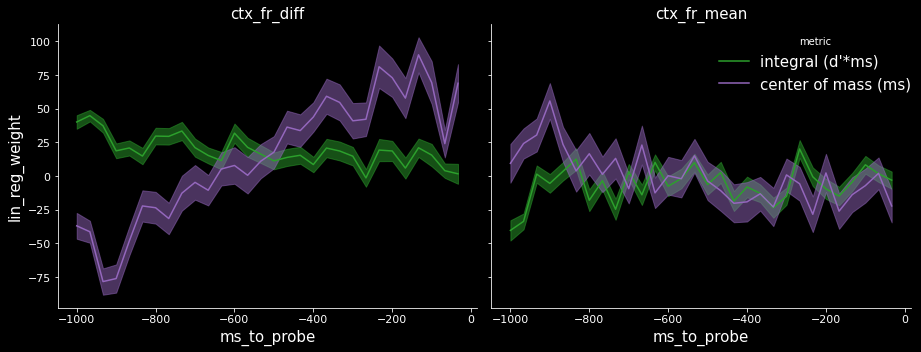

In [16]:
ctx_fr_ord = ['ctx_fr_diff', 'ctx_fr_mean']

g = sns.relplot(kind='line', data=all_weights,x='ms_to_probe', y='lin_reg_weight',
                hue='metric', hue_order=met_ord, palette=met_color,
                col='ctx_fr_type', col_order=ctx_fr_ord,
                legend=True, facet_kws={'legend_out':True})

t = all_confint['ms_to_probe'].unique()
t.sort()
for ctx_fr_type, ax in g.axes_dict.items():
    for metric, color in zip(met_ord, met_color):
        toplot = all_confint.query('ctx_fr_type == @ctx_fr_type and metric == @metric')
        ax.fill_between(t, toplot['lower'], toplot['upper'], color=color, alpha=0.5)
g.set_titles(row_template="", col_template="{col_name}")

g.legend.set_bbox_to_anchor((1, 0.8))

title = 'multivariate regression weights'
savefig(g.fig, 'ctx_fr', title, transparent=True)

### In Conclusion
After some back and forth with Stephen, it seems that the metrics for contextual modulation are already too digested,
so the regression and its implications are unclear. An alternative to this analysis, is to relate the difference of
context firing rate to the differences in the context modulated probe response, in a time by time way.

This sounds as effectively redoing my whole analysis, in a slightly different way.